In [1]:
import QPIXL.helper as hlp
from QPIXL.qiskit.qpixl_parallel import cFRQI
from qiskit_aer import StatevectorSimulator
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

backend = StatevectorSimulator(method="statevector")

# SOLVED - Bug with different sized inputs
See how to properly use the fixed "pad_0" function

ALL IMAGES WILL BE PADDED TO 4096


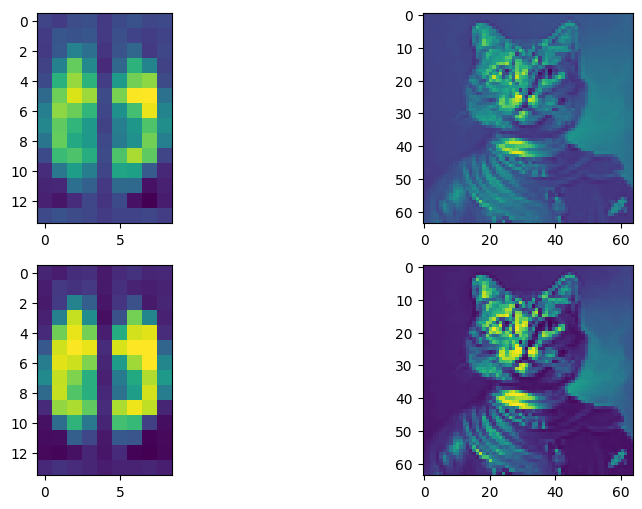

In [2]:
img = Image.open("figures/creation_world.png")
img = img.convert("L")
img = np.array(
    img.resize((9,14), Image.Resampling.LANCZOS),
    dtype=np.float32 # convert to float32 to avoid int overflow and correct colors
)

img2 = Image.open("figures/cat.webp")
img2 = img2.convert("L")
img2 = np.array(
    img2.resize((64, 64), Image.Resampling.LANCZOS),
    dtype=np.float32 # convert to float32 to avoid int overflow and correct colors
    )

shapes = np.array([
    img.shape,
    img2.shape
])

# Determine the max padding size
max_pad_size = hlp.nextpow2(np.max(shapes[:,0] * shapes[:, 1]))
print(f"ALL IMAGES WILL BE PADDED TO {max_pad_size}")

# Plot images for reference
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
axs[0][0].imshow(img)
axs[0][1].imshow(img2)

# Transpose images and pad them
padded_img = hlp.pad_0(img.T, size_pow2=max_pad_size)
padded_img2 = hlp.pad_0(img2.T, size_pow2=max_pad_size)

# Use padded images to build and run the circuit
np_frame = [padded_img, padded_img2]
decoded_data = []
qc = cFRQI(np_frame, 0)
job = backend.run(qc)

# Decode images without padding
sv = np.real(job.result().get_statevector())
decoded = hlp.decodeParallelQPIXL(sv, qc, len(np_frame))
for datum, shape in zip(decoded, shapes):
    decoded_data.append(hlp.reconstruct_img(datum, shape))

# Plot resulting images for comparison
axs[1][0].imshow(decoded_data[0])
axs[1][1].imshow(decoded_data[1])

# RANDOMIZED TESTING #
I've included a randomized "testing" cell below - it picks a number of batches of images, resizes them at a random shape and tests to see if the method works.

All randomized parameters are confined to some values, defined at the beginning of the cell. Feel free to try out with different values.

Test 0 starting
This test works with a batch of 3 images
Image 0 will be resized to shape [34  7]
Image 1 will be resized to shape [48 32]
Image 2 will be resized to shape [ 9 12]
Test 1 starting
This test works with a batch of 4 images
Image 0 will be resized to shape [64 29]
Image 1 will be resized to shape [ 6 31]
Image 2 will be resized to shape [16 44]
Image 3 will be resized to shape [62 49]
Test 2 starting
This test works with a batch of 5 images
Image 0 will be resized to shape [26 17]
Image 1 will be resized to shape [39 54]
Image 2 will be resized to shape [31 56]
Image 3 will be resized to shape [21 24]
Image 4 will be resized to shape [63 40]
Test 3 starting
This test works with a batch of 2 images
Image 0 will be resized to shape [ 9 23]
Image 1 will be resized to shape [12 13]
Test 4 starting
This test works with a batch of 3 images
Image 0 will be resized to shape [23 43]
Image 1 will be resized to shape [60 38]
Image 2 will be resized to shape [40 20]


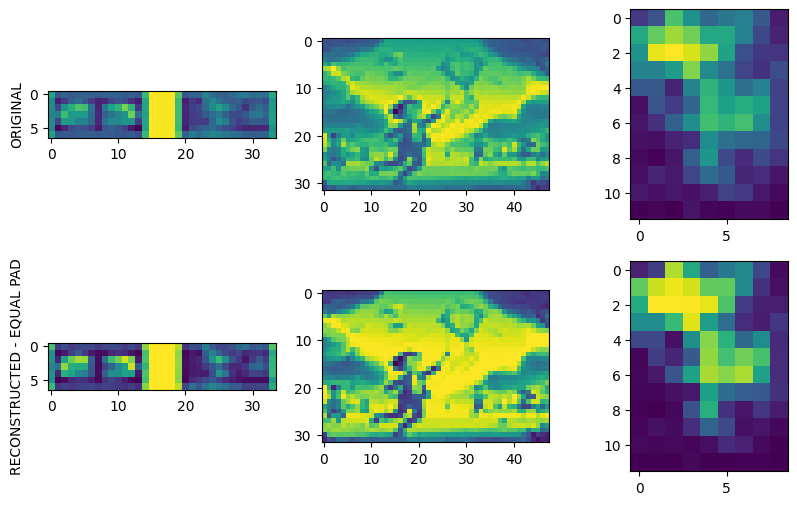

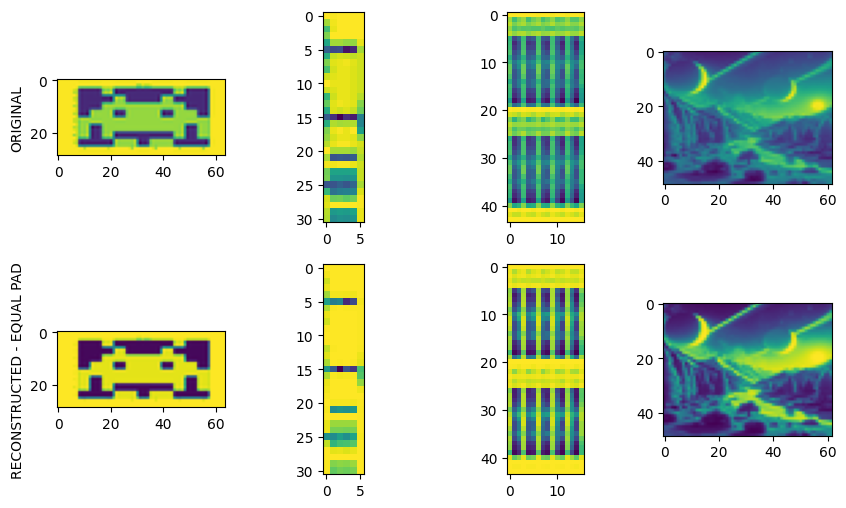

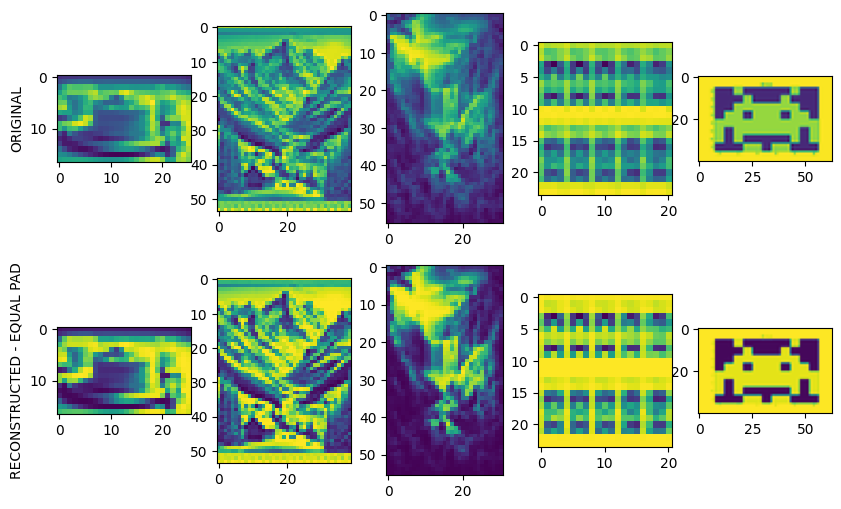

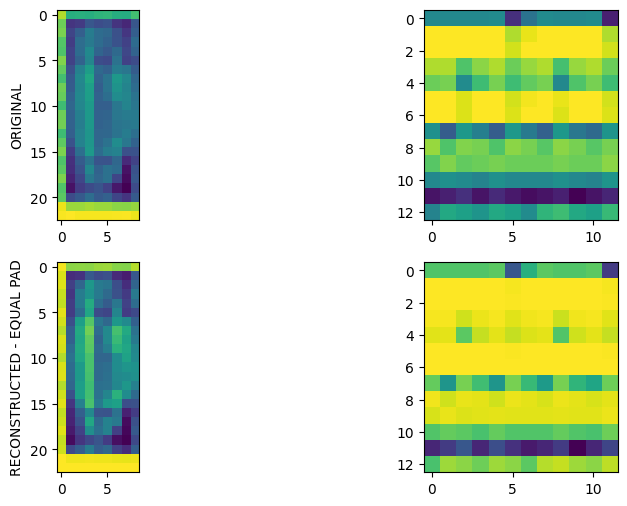

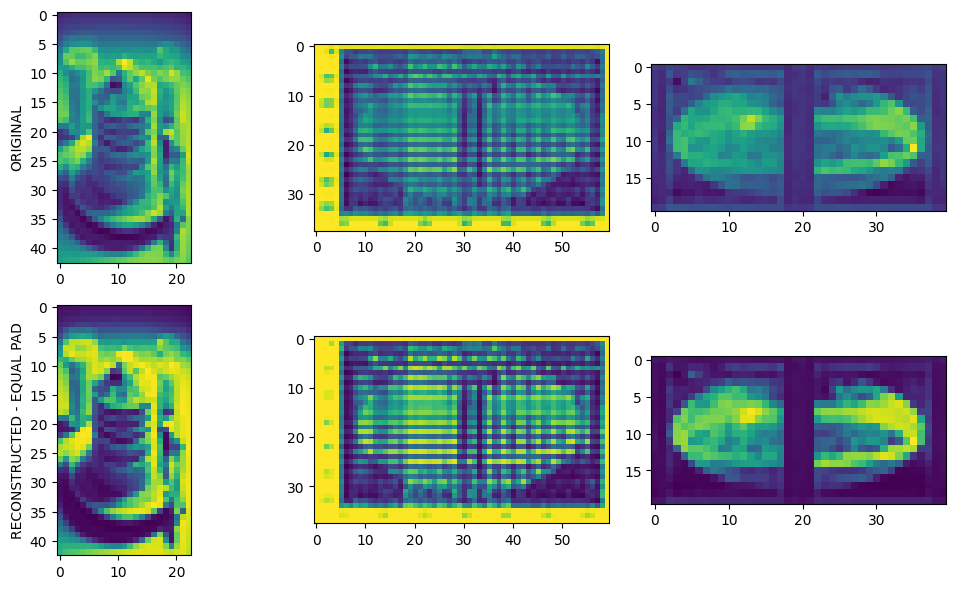

In [6]:
import os

# Change the default INT values to your liking, keep in mind not to overdo it
IMG_FOLDER_PATH = "figures"
ALL_IMAGE_PATHS = list(os.walk(IMG_FOLDER_PATH))[0][2]
NUM_OF_TESTS = 5
MAX_VALID_IMG_DIM = 64
MIN_VALID_IMG_DIM = 5
MAX_NUM_IMAGES_AT_ONCE = 5

for test_num in range(NUM_OF_TESTS):
    print(f"Test {test_num} starting")
    num_of_images = np.random.randint(2, MAX_NUM_IMAGES_AT_ONCE+1)
    print(f"This test works with a batch of {num_of_images} images")

    fig, axs = plt.subplots(2, num_of_images, figsize=(10, 6))
    axs[0][0].set_ylabel("ORIGINAL")
    axs[1][0].set_ylabel("RECONSTRUCTED - EQUAL PAD")
    
    img_shapes = []
    np_frame = []
    np_frame_equally_padded = []
    decoded_data = []

    # pre-generate the new shapes, so the maximum padding size can be known upfront
    new_shapes = np.array([(
        np.random.randint(MIN_VALID_IMG_DIM, MAX_VALID_IMG_DIM + 1),
        np.random.randint(MIN_VALID_IMG_DIM, MAX_VALID_IMG_DIM + 1)
        ) for _ in range(num_of_images)])
    
    max_pad_size = hlp.nextpow2(np.max(new_shapes[:,0] * new_shapes[:,1]))
    
    for image_num in range(num_of_images):
        # Randomly select and load the image, convert to grayscale
        img_path = os.path.join(IMG_FOLDER_PATH, np.random.choice(ALL_IMAGE_PATHS))
        img = Image.open(img_path)
        img = img.convert("L")

        # Select the randomly generated size of the image
        print(f"Image {image_num} will be resized to shape {new_shapes[image_num]}")
        
        img = np.array(
            img.resize(new_shapes[image_num], Image.Resampling.LANCZOS),
            dtype=np.float32 # convert to float32 to avoid int overflow and correct colors
        )
        img_shapes.append(img.shape)
        axs[0][image_num].imshow(img)

        # Transpose and pad image, add it to the np_frame
        np_frame.append(hlp.pad_0(img.T))
        np_frame_equally_padded.append(hlp.pad_0(img.T, size_pow2=max_pad_size))
    
    # Build the cFRQI circuit with equal padded inputs, run the job
    qc_equal_padding = cFRQI(np_frame_equally_padded, 0)
    job = backend.run(qc_equal_padding)
    sv = np.real(job.result().get_statevector())
    decoded = hlp.decodeParallelQPIXL(sv, qc_equal_padding, len(np_frame))
    for num_img, (datum, shape) in enumerate(zip(decoded, img_shapes)):
        reconstructed_img = hlp.reconstruct_img(datum, shape)
        decoded_data.append(reconstructed_img)
        axs[1][num_img].imshow(reconstructed_img)


plt.tight_layout()